Capstone Project Notebook Coursera

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Download Data File

In [3]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-06-30 02:41:43--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-06-30 02:41:43 (166 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Data visualization and pre-processing

Let’s see how many of each class is in our data set

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Let's plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



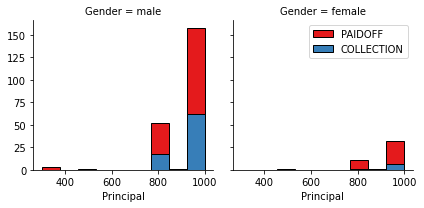

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

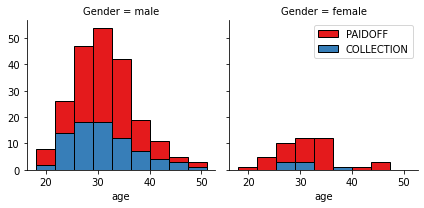

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Pre-processing:  Feature selection/extraction

### Let's look at the day of the week people get the loan

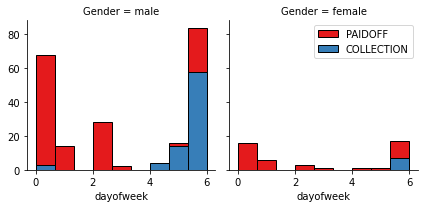

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Let's convert male to 0 and female to 1:

In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

### Features before One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

#### Import library
Classifier implementing the k-nearest neighbors vote.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Training

Let's start the algorithm with k=4 for now:

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
#Train Model and Predict  
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [25]:
# Hyperparameter Tuning
neigh_cv = KNeighborsClassifier()

grid_param = { 'n_neighbors' : (1,10, 1),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
                'leaf_size' : range(1,40,1),
                'p': [1,2]}

grid_search = GridSearchCV( estimator = neigh_cv, param_grid = grid_param, n_jobs=1, cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'leaf_size': range(1, 40),
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': (1, 10, 1), 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [26]:
# Show best parameters
grid_search.best_params_

{'leaf_size': 6,
 'metric': 'minkowski',
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [27]:
K = 25
mean_accuracy = np.zeros((K-1))
std_accuracy = np.zeros((K-1))

for n in range(1,K):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n, leaf_size= 6, metric= 'minkowski', p= 2, weights= 'uniform').fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_accuracy[n-1] = metrics.accuracy_score(y_test, yhat)

    std_accuracy[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


max_val = np.max(mean_accuracy)
location = np.where(mean_accuracy == max_val)

high_k = location[0][0]
print("Accuracy is the highest when K = {0} and its value = {1}". format(str(high_k+1), str(max_val) ))

Accuracy is the highest when K = 18 and its value = 0.8428571428571429


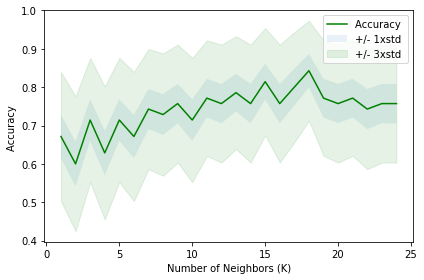

In [28]:
plt.plot(range(1, K),mean_accuracy,'g')
plt.fill_between(range(1, K), mean_accuracy - 1 * std_accuracy, mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.fill_between(range(1, K), mean_accuracy - 3 * std_accuracy, mean_accuracy + 3 * std_accuracy, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [29]:
print( "The best accuracy was with", mean_accuracy.max(), "with k=", mean_accuracy.argmax()+1) 

The best accuracy was with 0.8428571428571429 with k= 18


# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [31]:
# Hyperparameter Tuning
tree_cv = DecisionTreeClassifier()

grid_param = {  'max_depth': range(1,20,1),
                'min_samples_leaf': range(5,200,5),
                'max_features': ['auto','log2'],
                'criterion': ['gini', 'entropy'],
                'random_state':[0]
             }

grid_search = GridSearchCV( estimator = tree_cv, param_grid = grid_param, n_jobs=1, cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': range(5, 200, 5),
                         'random_state': [0]})

In [32]:
# Show best parameters
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'random_state': 0}

In [33]:
tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 4, max_features= 'auto', min_samples_leaf= 5, random_state= 4)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_features='auto', min_samples_leaf=5,
                       random_state=4)

In [34]:
predict_tree = tree.predict(X_test)

In [35]:
accuracy = metrics.accuracy_score(y_test, predict_tree)
print( "The accuracy score is {0}".format( accuracy)) 

The accuracy score is 0.8285714285714286


# Support Vector Machine


In [36]:
from sklearn.svm import SVC  

# Hyperparameter Tuning
svc_cv = SVC()

grid_param = {  'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly', 'rbf', 'sigmoid']
             }

grid_search = GridSearchCV( estimator = svc_cv, param_grid = grid_param, n_jobs=1, cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [37]:
# Show best parameters
grid_search.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [38]:
clf = SVC(C=0.1, gamma= 1, kernel= 'rbf')
clf.fit(X_train, y_train) 

SVC(C=0.1, gamma=1)

In [39]:
yhat = clf.predict(X_test)

In [40]:
 metrics.accuracy_score(y_test, yhat)

0.8285714285714286

# Logistic Regression


In [41]:
# import require libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [87]:
# Hyperparameter Tuning
LR_cv = LogisticRegression()

grid_param =   {    'C' : np.logspace(-4, 4, 10),
    'solver' : ['lbfgs','saga'],
    'max_iter' : [5000]
    
    }

grid_search = GridSearchCV( estimator = LR_cv, param_grid = grid_param, n_jobs=1, cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'max_iter': [5000], 'solver': ['lbfgs', 'saga']})

In [43]:
# Show best parameters
grid_search.best_params_

{'C': 0.0001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [44]:
# fit the model
regression = LogisticRegression(C= 0.0001, max_iter= 100, penalty= 'l1', solver= 'saga', random_state=0).fit(X_train,y_train)
regression_yhat = regression.predict(X_test)
yhat_proba = regression.predict_proba(X_test)

In [45]:
print("predicted: ", yhat[0:5])
print("test set: ", y_test[0:5])
print("proba: ", yhat_proba[0:5])
print("Accuracy: ", accuracy_score(y_test, regression_yhat))

predicted:  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
test set:  ['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
proba:  [[0.29222985 0.70777015]
 [0.29222985 0.70777015]
 [0.29222985 0.70777015]
 [0.29222985 0.70777015]
 [0.29222985 0.70777015]]
Accuracy:  0.8285714285714286


# Model Evaluation using Test set


In [46]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [47]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-06-30 02:43:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-06-30 02:43:08 (63.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation

In [48]:
test_df = pd.read_csv('loan_test.csv')
y_true = test_df['loan_status'].values
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## convert to date time object

In [49]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


## Pre-processing:  Feature selection/extraction
### Let's look at the day of the week people get the loan


In [50]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [51]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


## Convert Categorical features to numerical values
Let's look at gender:

In [52]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64


72 % of female pay there loans while 74 % of males pay there loan

Let's convert male to 0 and female to 1:


In [53]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


## One Hot Encoding
### How about education?

In [54]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

### Features before One Hot Encoding

In [55]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [56]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Feature Selection

In [57]:
test_X = Feature
test_X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [58]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data
Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [59]:
TEST_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
TEST_Y = test_df['loan_status'].values

In [60]:
knn_pred=neigh.predict(TEST_X)
jc1=jaccard_score(TEST_Y, knn_pred, pos_label='PAIDOFF')
fs1=f1_score(TEST_Y, knn_pred, average='weighted')

In [61]:
tree_pred=tree.predict(TEST_X)
jc2=jaccard_score(TEST_Y, tree_pred, pos_label='PAIDOFF')
fs2=f1_score(TEST_Y, tree_pred, average='weighted')

In [62]:
svm_pred=clf.predict(TEST_X)
jc3=jaccard_score(TEST_Y, svm_pred, pos_label='PAIDOFF')
fs3=f1_score(TEST_Y, svm_pred, average='weighted')

In [63]:
log_pred=regression.predict(TEST_X)
proba=regression.predict_proba(TEST_X)
jc4=jaccard_score(TEST_Y, log_pred, pos_label='PAIDOFF')
fs4=f1_score(TEST_Y, log_pred, average='weighted')  
ll4=log_loss(TEST_Y, proba)

In [64]:
list_jc = [jc1, jc2, jc3, jc4]
list_fs = [fs1, fs2, fs3, fs4]
list_ll = ['NA', 'NA', 'NA', ll4]

In [65]:
# fomulate the report format
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM','LogisticRegression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.740000,0.728821,NA
Decision Tree,0.740741,0.630418,NA
SVM,0.740741,0.630418,NA
LogisticRegression,0.740741,0.630418,0.574971
